In [74]:
import copy
import matplotlib.patches as patches
import Metrica_Viz as mviz
import Metrica_IO as mio
import numpy as np
import pandas as pd
from cmap import Colormap
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering, BisectingKMeans, KMeans, SpectralClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances

In [75]:
color_map = [
    "#FF0000",  # Red
    "#00FF00",  # Lime
    "#0000FF",  # Blue
    "#FFA500",  # Orange
    "#800080",  # Purple
    "#00FFFF",  # Cyan
    "#FF00FF",  # Magenta
    "#008000",  # Green
    "#FFC0CB",  # Pink
    "#8B4513",  # Saddle Brown
    "#FFD700",  # Gold
]
BALL_POSSESSION_SPEED = 0.05
MPS_TO_MPH = 2.23694
player_pos = ["P_1", "P_2", "P_3", "P_4", "P_5", "P_6", "P_7", "P_8", "P_9", "P_10", "P_11", "P_25", "P_15", "P_16", "P_17", "P_18", "P_19", "P_20", "P_21", "P_22", "P_23", "P_24"] # TODO: MIGHT BE FIX THIS LATER

In [76]:
df_home = pd.read_csv("Sample_Game_2_RawTrackingData_Home_Team.csv", low_memory=False)
df_away = pd.read_csv("Sample_Game_2_RawTrackingData_Away_Team.csv", low_memory=False)

In [77]:
ball_x = pd.to_numeric(df_home["Unnamed: 31"], errors='coerce')
ball_y = pd.to_numeric(df_home["Unnamed: 32"], errors='coerce')

In [78]:
df_home = df_home.iloc[2:].reset_index(drop=True)
last, bef_last = df_home.columns[-2:]
df_home.rename(columns={last: "ball-x", bef_last: "ball-y"}, inplace=True)
columns_to_drop = df_home.columns[(df_home.iloc[0].isna()) & (~df_home.columns.isin(["ball-x", "ball-y"]))]
df_home = df_home.drop(columns=columns_to_drop)
df_home.index = range(1, len(df_home) + 1)

In [79]:
df_home

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Home,Unnamed: 4,Home.1,Unnamed: 6,Home.2,Unnamed: 8,Home.3,...,Home.7,Unnamed: 18,Home.8,Unnamed: 20,Home.9,Unnamed: 22,Home.10,Unnamed: 24,ball-x,ball-y
1,1,1,0.04,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,NaN,NaN
2,1,2,0.08,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,NaN,NaN
3,1,3,0.12,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,NaN,NaN
4,1,4,0.16,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,NaN,NaN
5,1,5,0.2,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2,141152,5646.08,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,NaN,...,NaN,NaN,0.28426,0.35845,NaN,NaN,0.06285,0.51243,NaN,NaN
141153,2,141153,5646.12,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,NaN,...,NaN,NaN,0.28365,0.35933,NaN,NaN,0.06285,0.51243,NaN,NaN
141154,2,141154,5646.16,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,NaN,...,NaN,NaN,0.28322,0.36067,NaN,NaN,0.06285,0.51243,NaN,NaN
141155,2,141155,5646.2,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,NaN,...,NaN,NaN,0.28266,0.36095,NaN,NaN,0.06285,0.51243,NaN,NaN


In [80]:
df_away = df_away.iloc[2:].reset_index(drop=True)
last, bef_last = df_away.columns[-2:]
df_away.rename(columns={last: "ball-x", bef_last: "ball-y"}, inplace=True)
columns_to_drop = df_away.columns[(df_away.iloc[0].isna()) & (~df_away.columns.isin(["ball-x", "ball-y"]))]
df_away = df_away.drop(columns=columns_to_drop)
df_away.index = range(1, len(df_away) + 1)

In [81]:
df_away

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Away,Unnamed: 4,Away.1,Unnamed: 6,Away.2,Unnamed: 8,Away.3,...,Away.7,Unnamed: 18,Away.8,Unnamed: 20,Away.9,Unnamed: 22,Away.10,Unnamed: 24,ball-x,ball-y
1,1,1,0.04,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,NaN,NaN
2,1,2,0.08,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,NaN,NaN
3,1,3,0.12,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,NaN,NaN
4,1,4,0.16,0.01218,0.51763,0.32836,0.81847,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,NaN,NaN
5,1,5,0.2,0.01218,0.51763,0.32783,0.81847,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2,141152,5646.08,0.91211,0.48311,0.49028,-0.05000,0.48911,0.44788,0.59788,...,0.46751,1.05000,NaN,NaN,0.26855,0.61845,0.3676,0.12496,NaN,NaN
141153,2,141153,5646.12,0.91191,0.48311,0.49028,-0.05000,0.48894,0.44761,0.59767,...,0.4679,1.05000,NaN,NaN,0.26855,0.61845,0.3676,0.12496,NaN,NaN
141154,2,141154,5646.16,0.91168,0.48311,0.49028,-0.05000,0.48888,0.44684,0.59763,...,0.46818,1.05000,NaN,NaN,0.26855,0.61845,0.3676,0.12496,NaN,NaN
141155,2,141155,5646.2,0.91151,0.48311,0.49028,-0.05000,0.48895,0.44457,0.59775,...,0.46855,1.05000,NaN,NaN,0.26855,0.61845,0.3676,0.12496,NaN,NaN


In [249]:
def change_player_name(data: pd.Series) -> pd.Series:
    result = []
    name = ""
    for i in range(len(data)):
        item = data.iloc[i]
        if len(item) == 8:
            if int(item[-2:]) < 12:
                name = f"Home-P_{item[-2:]}"
            else:
                name = f"Away-P_{item[-2:]}"
        else:
            name = f"Home-P_{item[-1:]}"
            
        result.append(name)

    return pd.Series(data=result, name=data.name)

In [82]:
def add_headers(data: pd.DataFrame, team: str, start: int, end: int) -> list[str]:
    headers = []
    
    if team == "Home":
        headers.extend([f"{team}-P_1-x", f"{team}-P_1-y"])
    
    for i in range(start, end):
        player_index = i - start + (1 if team == "Home" else 11)
        
        headers.append(f"{team}-{player_pos[player_index]}-x")
        headers.append(f"{team}-{player_pos[player_index]}-y")

    headers = ["Period", "Frame", "Time[s]"] + headers + ["ball-x", "ball-y"]
    return headers

df_home.columns = add_headers(df_home, "Home", 2, 12)
df_away.columns = add_headers(df_away, "Away", 12, 23)

In [245]:
df_home["Period"].name

'Period'

In [83]:
df_home.head()

,Period,Frame,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,...,Home-P_8-x,Home-P_8-y,Home-P_9-x,Home-P_9-y,Home-P_10-x,Home-P_10-y,Home-P_11-x,Home-P_11-y,ball-x,ball-y
1,1,1,0.04,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,NaN,NaN
2,1,2,0.08,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,NaN,NaN
3,1,3,0.12,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,NaN,NaN
4,1,4,0.16,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,NaN,NaN
5,1,5,0.2,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,NaN,NaN


In [84]:
df_away.head()

,Period,Frame,Time[s],Away-P_25-x,Away-P_25-y,Away-P_15-x,Away-P_15-y,Away-P_16-x,Away-P_16-y,Away-P_17-x,...,Away-P_21-x,Away-P_21-y,Away-P_22-x,Away-P_22-y,Away-P_23-x,Away-P_23-y,Away-P_24-x,Away-P_24-y,ball-x,ball-y
1,1,1,0.04,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,NaN,NaN
2,1,2,0.08,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,NaN,NaN
3,1,3,0.12,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,NaN,NaN
4,1,4,0.16,0.01218,0.51763,0.32836,0.81847,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,NaN,NaN
5,1,5,0.2,0.01218,0.51763,0.32783,0.81847,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,NaN,NaN


## You'll see the data goes from 0 to 1 on each axis. The coordiante (0,0) is the top left, (1,1) is the bottom right, and (0.5,0.5) is the kick off point.

In [85]:
df_home['Period'] = pd.to_numeric(df_home['Period'], errors='coerce')
period_1_data_home = df_home[df_home["Period"] == 1]

In [86]:
df_away['Period'] = pd.to_numeric(df_away['Period'], errors='coerce')
period_1_data_away = df_away[df_away["Period"] == 1]

In [87]:
# Dropping the rows where the ball's x-y coordinates are NaN
# period_1_data_home = period_1_data_home.dropna(subset=["ball-x", "ball-y"], how="any")
# period_1_data_away = period_1_data_away.dropna(subset=["ball-x", "ball-y"], how="any")

In [88]:
def fill_nan_with_adjacent_average(data: pd.DataFrame) -> pd.DataFrame:
    """
    Fill NaN values in a DataFrame with the average of previous and next non-NaN values.
    
    Parameters:
    df_home (pd.DataFrame): Input DataFrame
    
    Returns:
    pd.DataFrame: DataFrame with NaN values filled
    """
    # Create a copy of the input DataFrame to avoid modifying the original
    df_filled = data.copy()
    
    # Iterate through each column
    for col in df_filled.columns:
        if pd.api.types.is_numeric_dtype(df_filled[col]):
            df_filled[col] = df_filled[col].interpolate(method="linear")
        df_filled[col] = df_filled[col].ffill().bfill()
    
    return df_filled

In [89]:
period_1_data_home = fill_nan_with_adjacent_average(period_1_data_home)
period_1_data_away = fill_nan_with_adjacent_average(period_1_data_away)

In [90]:
period_1_data_home

,Period,Frame,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,...,Home-P_8-x,Home-P_8-y,Home-P_9-x,Home-P_9-y,Home-P_10-x,Home-P_10-y,Home-P_11-x,Home-P_11-y,ball-x,ball-y
1,1,1,0.04,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,0.50216,0.50376
2,1,2,0.08,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,0.50216,0.50376
3,1,3,0.12,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,0.50216,0.50376
4,1,4,0.16,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,0.50216,0.50376
5,1,5,0.2,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67937,1,67937,2717.48,0.51337,0.71683,0.52318,0.78966,0.54702,0.86195,0.51242,...,0.40066,0.50905,0.35073,0.59980,0.337,0.79222,0.81546,0.72958,0.00883,0.47469
67938,1,67938,2717.52,0.51339,0.71801,0.52312,0.79035,0.54692,0.86271,0.51242,...,0.40095,0.50993,0.35105,0.60026,0.33727,0.79263,0.81461,0.73064,0.00883,0.47469
67939,1,67939,2717.56,0.5134,0.71929,0.52312,0.79124,0.54677,0.86355,0.51242,...,0.40122,0.51062,0.35136,0.60081,0.33756,0.79303,0.81413,0.73124,0.00883,0.47469
67940,1,67940,2717.6,0.51342,0.72035,0.52315,0.79171,0.54673,0.86423,0.51242,...,0.40148,0.51078,0.35166,0.60165,0.33781,0.79344,0.81385,0.73124,0.00883,0.47469


In [91]:
period_1_data_away

,Period,Frame,Time[s],Away-P_25-x,Away-P_25-y,Away-P_15-x,Away-P_15-y,Away-P_16-x,Away-P_16-y,Away-P_17-x,...,Away-P_21-x,Away-P_21-y,Away-P_22-x,Away-P_22-y,Away-P_23-x,Away-P_23-y,Away-P_24-x,Away-P_24-y,ball-x,ball-y
1,1,1,0.04,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
2,1,2,0.08,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
3,1,3,0.12,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
4,1,4,0.16,0.01218,0.51763,0.32836,0.81847,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
5,1,5,0.2,0.01218,0.51763,0.32783,0.81847,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67937,1,67937,2717.48,0.00095,0.55662,0.40104,0.91503,0.33494,0.79087,0.3298,...,0.4305,0.63162,0.33736,0.43011,0.52637,0.93788,0.46338,0.61444,0.00883,0.47469
67938,1,67938,2717.52,0.00075,0.55671,0.40104,0.91503,0.33552,0.79133,0.33011,...,0.43062,0.63247,0.33727,0.43065,0.52626,0.93879,0.46345,0.61528,0.00883,0.47469
67939,1,67939,2717.56,0.00063,0.55671,0.40104,0.91503,0.33631,0.79184,0.33046,...,0.43075,0.63337,0.33729,0.43166,0.52624,0.93940,0.4636,0.61612,0.00883,0.47469
67940,1,67940,2717.6,0.00063,0.55671,0.40104,0.91503,0.33781,0.79344,0.3309,...,0.43091,0.63441,0.33734,0.43225,0.52621,0.94018,0.46374,0.61695,0.00883,0.47469


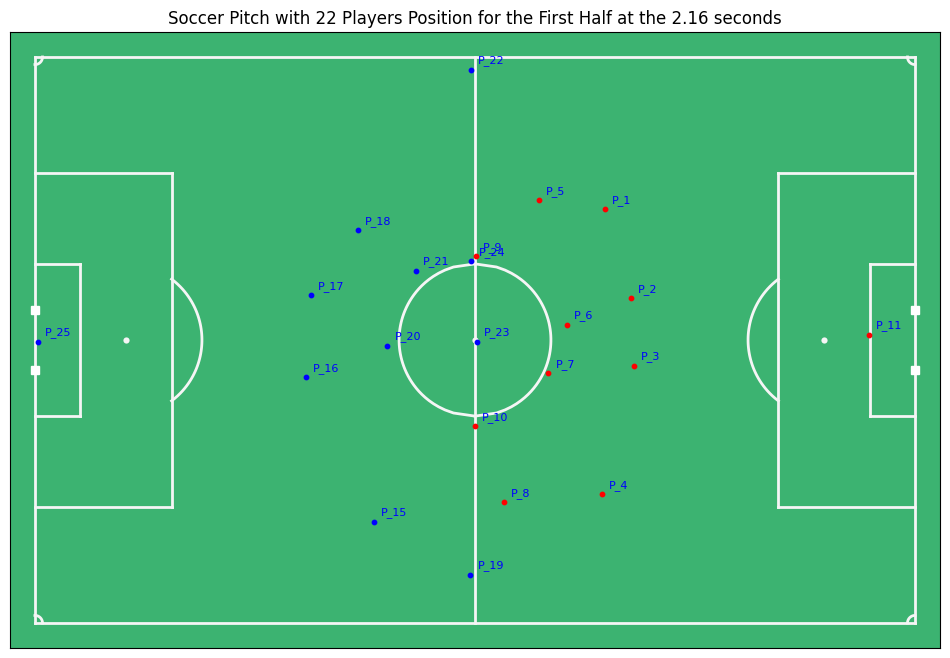

In [92]:
fig, ax = mviz.plot_pitch()

# Prepare player positions and their coordinates on the pitch
home_frame = period_1_data_home.iloc[53]
away_frame = period_1_data_away.iloc[53]
pos_x = [[float(home_frame.iloc[i]), period_1_data_home.columns[i]] for i in range(3, period_1_data_home.shape[1] - 2) if "-x" in period_1_data_home.columns[i]]
pos_y = [[float(home_frame.iloc[i]), period_1_data_home.columns[i]] for i in range(3, period_1_data_home.shape[1] - 2) if "-y" in period_1_data_home.columns[i]]
pos_x = pos_x + [[float(away_frame.iloc[i]), period_1_data_away.columns[i]] for i in range(3, period_1_data_away.shape[1]) if "-x" in period_1_data_away.columns[i]]
pos_y = pos_y + [[float(away_frame.iloc[i]), period_1_data_away.columns[i]] for i in range(3, period_1_data_away.shape[1]) if "-y" in period_1_data_away.columns[i]]

data_x, col_x = [item[0] for item in pos_x], [item[1] for item in pos_x]
data_y, col_y = [item[0] for item in pos_y], [item[1] for item in pos_y]

positions_x = pd.DataFrame([data_x], columns=col_x)
positions_y = pd.DataFrame([data_y], columns=col_y)

# Changing the dataset to meter or pitch coordinates
positions_x = mio.to_metric_coordinates(positions_x)
positions_y = mio.to_metric_coordinates(positions_y)

MEAN_X_POS = positions_x.mean(axis=1)[0]
DIRECTION_TO_GOAL = "<--" if MEAN_X_POS > 0 else "-->"
DIRECTION_TO_GOAL += " Direction To Goal"

# Annotate player names
for i, (x, y, name) in enumerate(zip(positions_x.iloc[0], positions_y.iloc[0], player_pos)):
    color = "red"
    if i > 10:
        color = "blue"
    ax.scatter(x, y, color=color, s=10, zorder=2)  # Plot red dot
    ax.annotate(name, (x, y), xytext=(5, 5), textcoords="offset points", fontsize=8, color='blue')
# ax.annotate(DIRECTION_TO_GOAL, (MEAN_X_POS, 29.55), xytext=(MEAN_X_POS, 29.55), textcoords="offset points", fontsize=18, color="red")

seconds = home_frame.iloc[2]
plt.title(f"Soccer Pitch with 22 Players Position for the First Half at the {seconds} seconds")
plt.show()

In [93]:
period_1_data_home

,Period,Frame,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,...,Home-P_8-x,Home-P_8-y,Home-P_9-x,Home-P_9-y,Home-P_10-x,Home-P_10-y,Home-P_11-x,Home-P_11-y,ball-x,ball-y
1,1,1,0.04,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,0.50216,0.50376
2,1,2,0.08,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,0.50216,0.50376
3,1,3,0.12,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,0.50216,0.50376
4,1,4,0.16,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,0.50216,0.50376
5,1,5,0.2,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67937,1,67937,2717.48,0.51337,0.71683,0.52318,0.78966,0.54702,0.86195,0.51242,...,0.40066,0.50905,0.35073,0.59980,0.337,0.79222,0.81546,0.72958,0.00883,0.47469
67938,1,67938,2717.52,0.51339,0.71801,0.52312,0.79035,0.54692,0.86271,0.51242,...,0.40095,0.50993,0.35105,0.60026,0.33727,0.79263,0.81461,0.73064,0.00883,0.47469
67939,1,67939,2717.56,0.5134,0.71929,0.52312,0.79124,0.54677,0.86355,0.51242,...,0.40122,0.51062,0.35136,0.60081,0.33756,0.79303,0.81413,0.73124,0.00883,0.47469
67940,1,67940,2717.6,0.51342,0.72035,0.52315,0.79171,0.54673,0.86423,0.51242,...,0.40148,0.51078,0.35166,0.60165,0.33781,0.79344,0.81385,0.73124,0.00883,0.47469


In [94]:
period_1_data_away

,Period,Frame,Time[s],Away-P_25-x,Away-P_25-y,Away-P_15-x,Away-P_15-y,Away-P_16-x,Away-P_16-y,Away-P_17-x,...,Away-P_21-x,Away-P_21-y,Away-P_22-x,Away-P_22-y,Away-P_23-x,Away-P_23-y,Away-P_24-x,Away-P_24-y,ball-x,ball-y
1,1,1,0.04,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
2,1,2,0.08,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
3,1,3,0.12,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
4,1,4,0.16,0.01218,0.51763,0.32836,0.81847,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
5,1,5,0.2,0.01218,0.51763,0.32783,0.81847,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67937,1,67937,2717.48,0.00095,0.55662,0.40104,0.91503,0.33494,0.79087,0.3298,...,0.4305,0.63162,0.33736,0.43011,0.52637,0.93788,0.46338,0.61444,0.00883,0.47469
67938,1,67938,2717.52,0.00075,0.55671,0.40104,0.91503,0.33552,0.79133,0.33011,...,0.43062,0.63247,0.33727,0.43065,0.52626,0.93879,0.46345,0.61528,0.00883,0.47469
67939,1,67939,2717.56,0.00063,0.55671,0.40104,0.91503,0.33631,0.79184,0.33046,...,0.43075,0.63337,0.33729,0.43166,0.52624,0.93940,0.4636,0.61612,0.00883,0.47469
67940,1,67940,2717.6,0.00063,0.55671,0.40104,0.91503,0.33781,0.79344,0.3309,...,0.43091,0.63441,0.33734,0.43225,0.52621,0.94018,0.46374,0.61695,0.00883,0.47469


## Tracking for individual Players for the First Period

In [95]:
period_1_data = pd.concat([period_1_data_home.iloc[:40000, :-2],  period_1_data_away.iloc[:40000, 3:]], axis=1)

In [96]:
period_1_data

,Period,Frame,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,...,Away-P_21-x,Away-P_21-y,Away-P_22-x,Away-P_22-y,Away-P_23-x,Away-P_23-y,Away-P_24-x,Away-P_24-y,ball-x,ball-y
1,1,1,0.04,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.503760
2,1,2,0.08,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.503760
3,1,3,0.12,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.503760
4,1,4,0.16,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.503760
5,1,5,0.2,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.503760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39996,1,39996,1599.84,0.75401,0.05765,0.80377,0.14736,0.82123,0.47841,0.79425,...,0.61583,0.42294,0.74865,0.33770,0.78715,0.48973,0.79312,0.09089,0.70164,-0.014510
39997,1,39997,1599.88,0.75494,0.05775,0.80455,0.14743,0.82165,0.47780,0.79469,...,0.61612,0.42254,0.74874,0.33695,0.78743,0.48877,0.79396,0.08936,0.70107,-0.016440
39998,1,39998,1599.92,0.75587,0.05785,0.80536,0.14751,0.82206,0.47718,0.79512,...,0.61644,0.42214,0.74883,0.33609,0.78764,0.48794,0.7948,0.08783,0.70049,-0.018360
39999,1,39999,1599.96,0.75679,0.05784,0.80614,0.14783,0.82244,0.47661,0.79555,...,0.61674,0.42173,0.74892,0.33541,0.78784,0.48710,0.79562,0.08641,0.70049,-0.018465


In [97]:
def player_tracking(dataset: pd.DataFrame, players: list[int] = [11], plot_ball: bool =True, use_annotation: bool = False, sides: list[str] = None, markersize: int = 7):
    fig, ax = mviz.plot_pitch()
    ball_is_not_there = plot_ball
    title = "Player, and Side at each intervals"
    if use_annotation:
        title = "Player, and Frame at each intervals"
    
    for i, (player, side) in enumerate(zip(players, sides)):
        x = f"{side}-P_{player}-x"
        y = f"{side}-P_{player}-y"
    
        # Prepare player positions and their coordinates on the pitch
        data_x = pd.to_numeric(dataset[x], errors='coerce')
        data_y = pd.to_numeric(dataset[y], errors='coerce')
        
        # Create DataFrames with a single column for x and y coordinate of a player
        positions_x = pd.DataFrame(data_x, columns=[x])
        positions_y = pd.DataFrame(data_y, columns=[y])
        
        # Changing the dataset to metric or pitch coordinates
        positions_x = mio.to_metric_coordinates(positions_x)
        positions_y = mio.to_metric_coordinates(positions_y)

        color = color_map[i % len(color_map)]
        
        # Plot player movement with arrows
        for j in range(len(positions_x) - 1):
            dx = positions_x[x].iloc[j+1] - positions_x[x].iloc[j]
            dy = positions_y[y].iloc[j+1] - positions_y[y].iloc[j]
            if abs(dx) > 0.1 or abs(dy) > 0.1:  # Only draw arrows for significant movements
                ax.arrow(positions_x[x].iloc[j], positions_y[y].iloc[j], dx, dy, head_width=1.2, head_length=1.2, fc=color, ec=color, linestyle="dotted", length_includes_head=True)

        # Plot the player path with dots and lines
        if use_annotation:
            for i in range(len(positions_x)):
                ax.plot(positions_x[x].iloc[i], positions_y[y].iloc[i], marker=".", linestyle="-.", markersize=markersize, color=color, zorder=3, label=f"P{use_annotation[i]} - {positions_x.index[i]}")
                ax.text(positions_x[x].iloc[i], positions_y[y].iloc[i], positions_x.index[i], fontsize=12, ha='right')
        else:
            ax.plot(positions_x[x], positions_y[y], marker=".", linestyle="-.", markersize=markersize, color=color, zorder=3, label=f"Player {player} - {side}")
        ax.plot(positions_x[x].iloc[0], positions_y[y].iloc[0], marker=".", linestyle="-.", markersize=int(markersize * 1.75), color="green", zorder=3)
        ax.plot(positions_x[x].iloc[-1], positions_y[y].iloc[-1], marker=".", linestyle="-.", markersize=int(markersize * 1.75), color="red", zorder=3)
                    
        # ax.annotate("Start Point", (positions_x[x].iloc[0], positions_y[y].iloc[0]), xytext=(5, 5), textcoords="offset points", fontsize=8, color=color)
        # ax.annotate("End Point", (positions_x[x].iloc[-1], positions_y[y].iloc[-1]), xytext=(5, 5), textcoords="offset points", fontsize=8, color=color)

    if ball_is_not_there:
        ba_x = pd.to_numeric(dataset["ball-x"], errors='coerce')
        ba_y = pd.to_numeric(dataset["ball-y"], errors='coerce')
        
        ba_x = mio.to_metric_coordinates(pd.DataFrame(ba_x, columns=["ball-x"]))
        ba_y = mio.to_metric_coordinates(pd.DataFrame(ba_y, columns=["ball-y"]))
        
        ax.plot(ba_x["ball-x"], ba_y["ball-y"], marker=".", linestyle="-.", markersize=int(markersize * 1.5), color="black", zorder=2, label="Ball")
        ax.plot(ba_x["ball-x"].iloc[0], ba_y["ball-y"].iloc[0], marker=".", linestyle="-.", markersize=int(markersize * 1.75), color="green", zorder=2)
        ax.plot(ba_x["ball-x"].iloc[-1], ba_y["ball-y"].iloc[-1], marker=".", linestyle="-.", markersize=int(markersize * 1.75), color="red", zorder=2)
        
        # Ball movement arrows
        for j in range(len(ba_x) - 1):
            dx = ba_x["ball-x"].iloc[j+1] - ba_x["ball-x"].iloc[j]
            dy = ba_y["ball-y"].iloc[j+1] - ba_y["ball-y"].iloc[j]
            if abs(dx) > 0.1 or abs(dy) > 0.1:  # Only draw arrows for significant movements
                ax.arrow(ba_x["ball-x"].iloc[j], ba_y["ball-y"].iloc[j], dx, dy, head_width=1.2, head_length=1.2, fc='black', ec='black', linestyle="dotted", length_includes_head=True)
                
        # ax.annotate("Start Point", (ba_x["ball-x"].iloc[0], ba_y["ball-y"].iloc[0]), xytext=(5, 5), textcoords="offset points", fontsize=8, color="black")
        # ax.annotate("End Point", (ba_x["ball-x"].iloc[-1], ba_y["ball-y"].iloc[-1]), xytext=(5, 5), textcoords="offset points", fontsize=8, color="black")
        
    ball_is_not_there = False
    
    start_seconds = dataset["Time[s]"].iloc[0]
    end_seconds = dataset["Time[s]"].iloc[-1]
    pl = [i for i in players]
    ax.set_title(f"Tracking for Player {pl} in the First Half from {start_seconds} seconds to {end_seconds} seconds")
    ax.legend(title=title, loc="upper left", fontsize=8)
        
    plt.tight_layout()
    plt.show()

In [98]:
# player_tracking(period_1_data_home)
# player_tracking(period_1_data_home, [2])
# player_tracking(period_1_data_home, [5])
# player_tracking(period_1_data_home, [8])

# Grouping players time interval on 1 second interval

In [99]:
period_1_data

,Period,Frame,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,...,Away-P_21-x,Away-P_21-y,Away-P_22-x,Away-P_22-y,Away-P_23-x,Away-P_23-y,Away-P_24-x,Away-P_24-y,ball-x,ball-y
1,1,1,0.04,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.503760
2,1,2,0.08,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.503760
3,1,3,0.12,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.503760
4,1,4,0.16,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.503760
5,1,5,0.2,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.503760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39996,1,39996,1599.84,0.75401,0.05765,0.80377,0.14736,0.82123,0.47841,0.79425,...,0.61583,0.42294,0.74865,0.33770,0.78715,0.48973,0.79312,0.09089,0.70164,-0.014510
39997,1,39997,1599.88,0.75494,0.05775,0.80455,0.14743,0.82165,0.47780,0.79469,...,0.61612,0.42254,0.74874,0.33695,0.78743,0.48877,0.79396,0.08936,0.70107,-0.016440
39998,1,39998,1599.92,0.75587,0.05785,0.80536,0.14751,0.82206,0.47718,0.79512,...,0.61644,0.42214,0.74883,0.33609,0.78764,0.48794,0.7948,0.08783,0.70049,-0.018360
39999,1,39999,1599.96,0.75679,0.05784,0.80614,0.14783,0.82244,0.47661,0.79555,...,0.61674,0.42173,0.74892,0.33541,0.78784,0.48710,0.79562,0.08641,0.70049,-0.018465


In [100]:
period_1_data = period_1_data.drop(columns=["Frame"])

In [101]:
period_1_data

,Period,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,Home-P_4-y,...,Away-P_21-x,Away-P_21-y,Away-P_22-x,Away-P_22-y,Away-P_23-x,Away-P_23-y,Away-P_24-x,Away-P_24-y,ball-x,ball-y
1,1,0.04,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.503760
2,1,0.08,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.503760
3,1,0.12,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.503760
4,1,0.16,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.503760
5,1,0.2,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.503760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39996,1,1599.84,0.75401,0.05765,0.80377,0.14736,0.82123,0.47841,0.79425,0.65911,...,0.61583,0.42294,0.74865,0.33770,0.78715,0.48973,0.79312,0.09089,0.70164,-0.014510
39997,1,1599.88,0.75494,0.05775,0.80455,0.14743,0.82165,0.47780,0.79469,0.65856,...,0.61612,0.42254,0.74874,0.33695,0.78743,0.48877,0.79396,0.08936,0.70107,-0.016440
39998,1,1599.92,0.75587,0.05785,0.80536,0.14751,0.82206,0.47718,0.79512,0.65805,...,0.61644,0.42214,0.74883,0.33609,0.78764,0.48794,0.7948,0.08783,0.70049,-0.018360
39999,1,1599.96,0.75679,0.05784,0.80614,0.14783,0.82244,0.47661,0.79555,0.65754,...,0.61674,0.42173,0.74892,0.33541,0.78784,0.48710,0.79562,0.08641,0.70049,-0.018465


In [102]:
# Convert all columns to numeric
temp_data = copy.deepcopy(period_1_data)
for col in temp_data.columns:
    if col != "Period" and col != "Time[s]":
        temp_data[col] = pd.to_numeric(temp_data[col], errors='coerce')
        period_1_data[col] = pd.to_numeric(period_1_data[col], errors='coerce')
    else:
        period_1_data[col] = pd.to_numeric(period_1_data[col], errors='coerce')
        temp_data[col] = pd.to_numeric(temp_data[col], errors='coerce').astype(int)

avg_1_sec = pd.DataFrame()

# Calculate averages for each column
for col in temp_data.columns:
    averages = []
    for i in range(0, len(temp_data), 25):
        group = temp_data[col].iloc[i:i+25]
        avg = group.mean()
        averages.append(avg)
    
    # Add the averages for this column to avg_1_sec
    avg_1_sec[col] = averages   

# avg_1_sec.reset_index(drop=True, inplace=True)
avg_1_sec.index = range(1, len(avg_1_sec) + 1)

In [103]:
avg_1_sec = avg_1_sec.iloc[:100]
avg_1_sec

,Period,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,Home-P_4-y,...,Away-P_21-x,Away-P_21-y,Away-P_22-x,Away-P_22-y,Away-P_23-x,Away-P_23-y,Away-P_24-x,Away-P_24-y,ball-x,ball-y
1,1.0,0.04,0.647560,0.283644,0.677520,0.428030,0.696592,0.555645,0.644147,0.762736,...,0.432839,0.357528,0.497823,0.014630,0.501770,0.501450,0.495170,0.362340,0.502160,0.503760
2,1.0,1.04,0.647150,0.275018,0.677629,0.426852,0.686746,0.549754,0.644875,0.767359,...,0.432688,0.377177,0.495778,0.024554,0.501954,0.502422,0.495172,0.362320,0.502160,0.503760
3,1.0,2.04,0.649075,0.267862,0.677262,0.426183,0.676346,0.545278,0.643126,0.777459,...,0.434040,0.376211,0.495640,0.021007,0.502760,0.504104,0.497760,0.361457,0.470664,0.505236
4,1.0,3.04,0.650808,0.270631,0.675158,0.425478,0.665320,0.549432,0.641822,0.791985,...,0.439949,0.372589,0.504589,0.017182,0.511515,0.507609,0.511674,0.367192,0.412815,0.508063
5,1.0,4.04,0.651694,0.280151,0.676261,0.421896,0.657516,0.555598,0.646048,0.804760,...,0.454579,0.368341,0.529735,0.012959,0.534513,0.518531,0.539336,0.385298,0.412500,0.510373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1.0,95.04,0.684736,0.347691,0.705132,0.574020,0.665660,0.796998,0.533835,0.991324,...,0.469611,0.830619,0.620249,0.513454,0.661462,0.415208,0.592110,0.820090,0.574086,0.918220
97,1.0,96.04,0.688511,0.359455,0.723160,0.610179,0.665004,0.853710,0.560912,0.988387,...,0.490528,0.845969,0.627039,0.527022,0.669124,0.444810,0.615717,0.850423,0.628999,0.855877
98,1.0,97.04,0.691733,0.361788,0.740839,0.634582,0.672151,0.896891,0.585750,0.973080,...,0.507897,0.858088,0.631694,0.543294,0.670372,0.478440,0.637200,0.843921,0.539116,0.927579
99,1.0,98.04,0.692347,0.360227,0.740757,0.642786,0.690913,0.911300,0.597130,0.961983,...,0.520422,0.861600,0.631526,0.561417,0.665106,0.507191,0.637781,0.829780,0.527116,0.945611


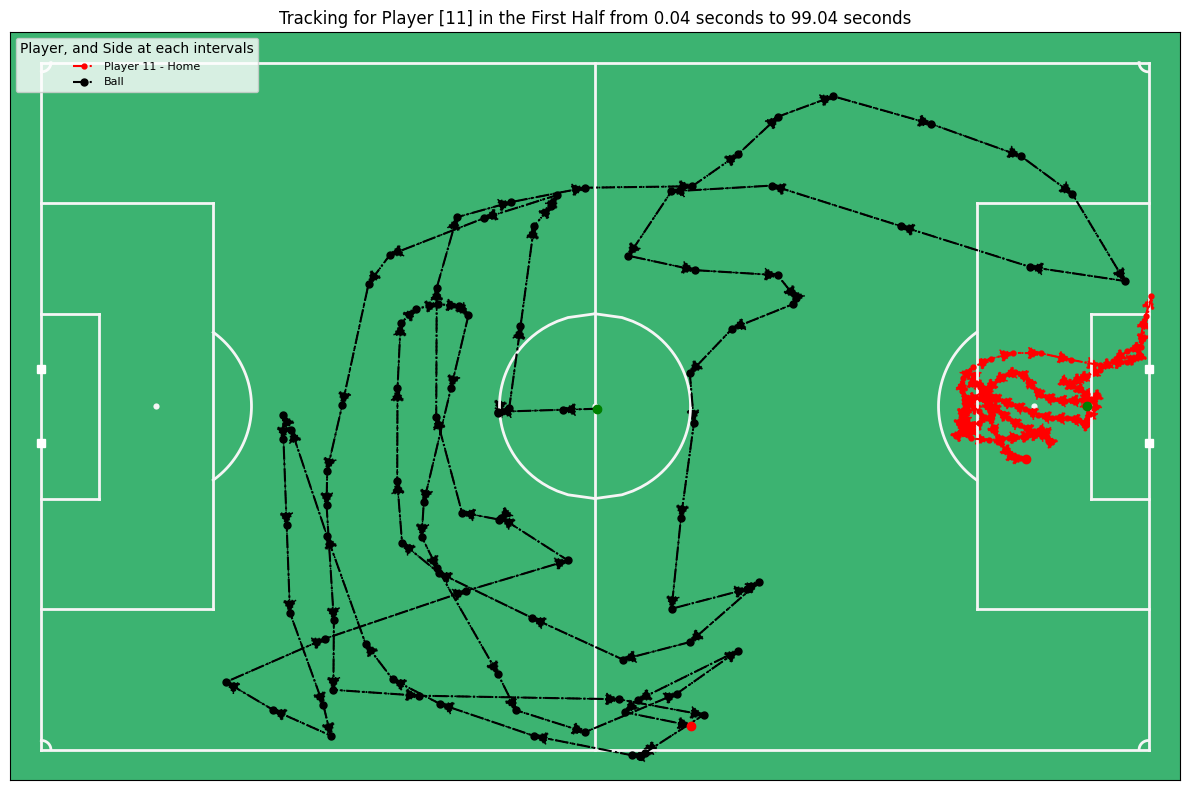

In [104]:
player_tracking(avg_1_sec.loc[:"Home-P_11-y"], plot_ball=True, sides=["Home"]*avg_1_sec.loc[:"Home-P_11-y"].shape[1])

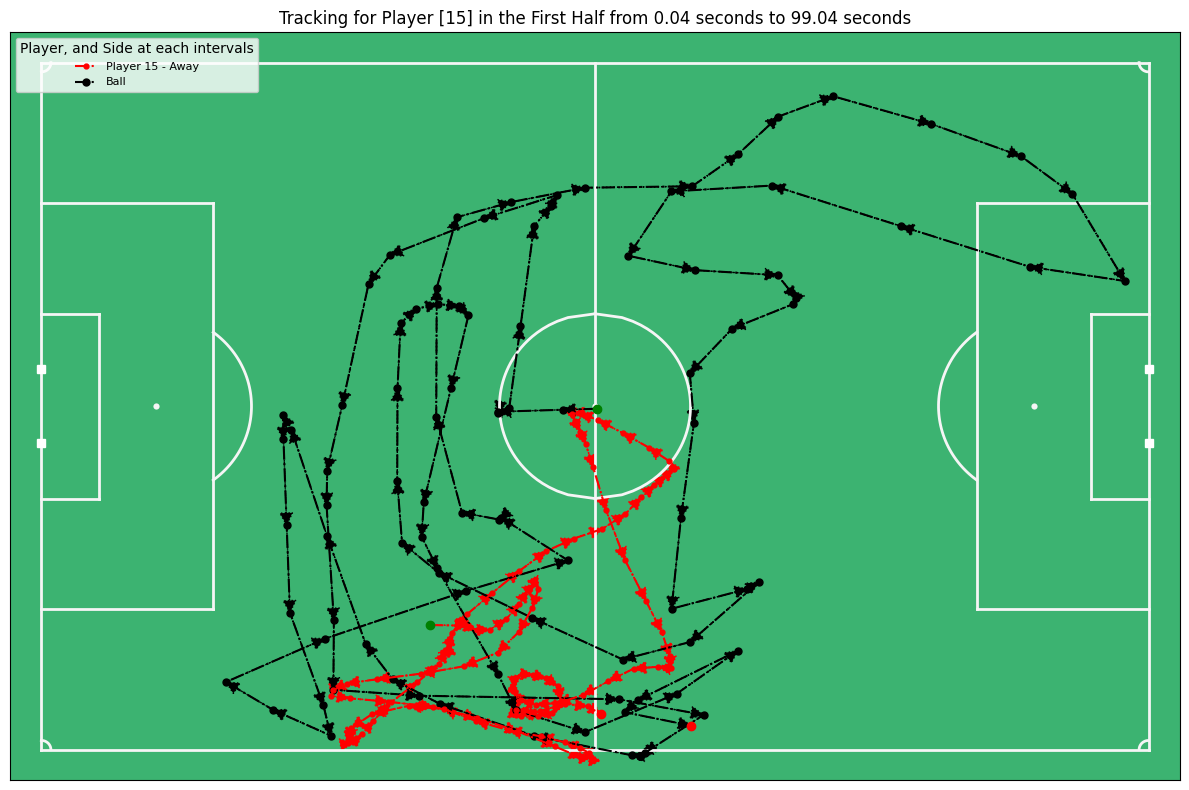

In [105]:
player_tracking(avg_1_sec, [15], sides=["Away"]*1)

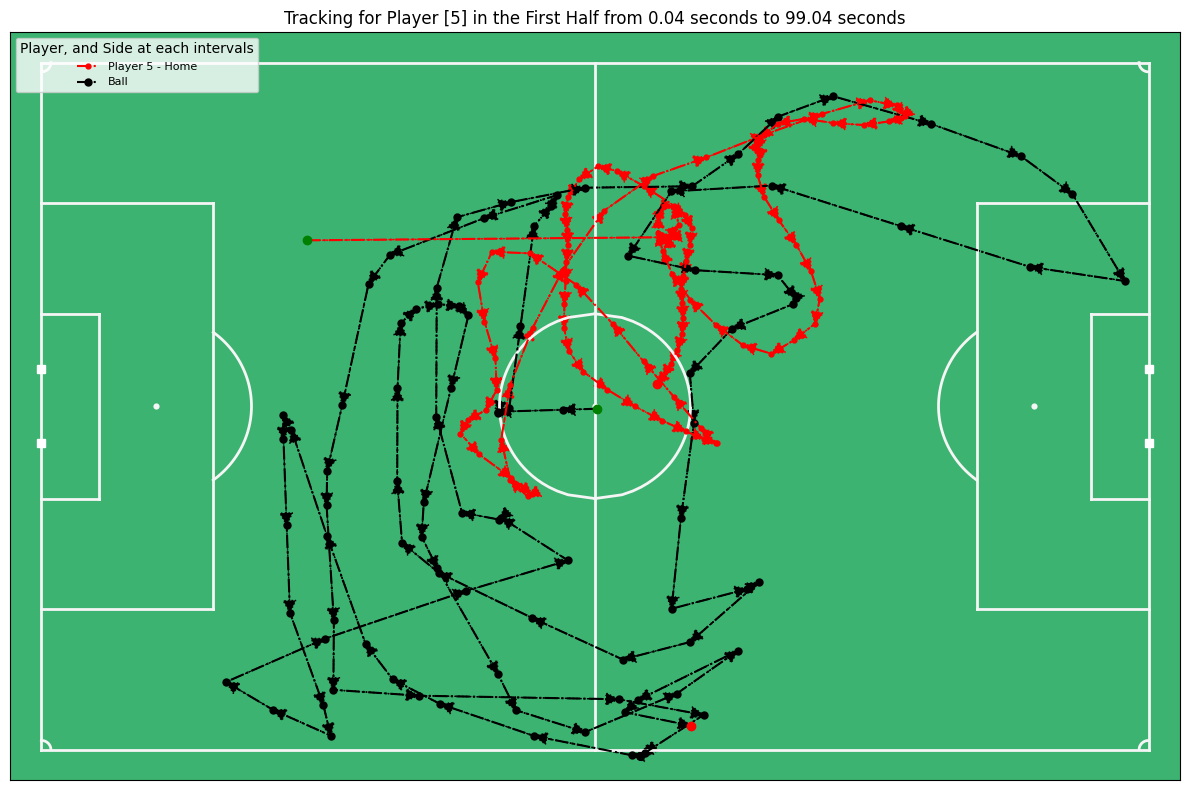

In [106]:
player_tracking(avg_1_sec, [5], sides=["Home"])

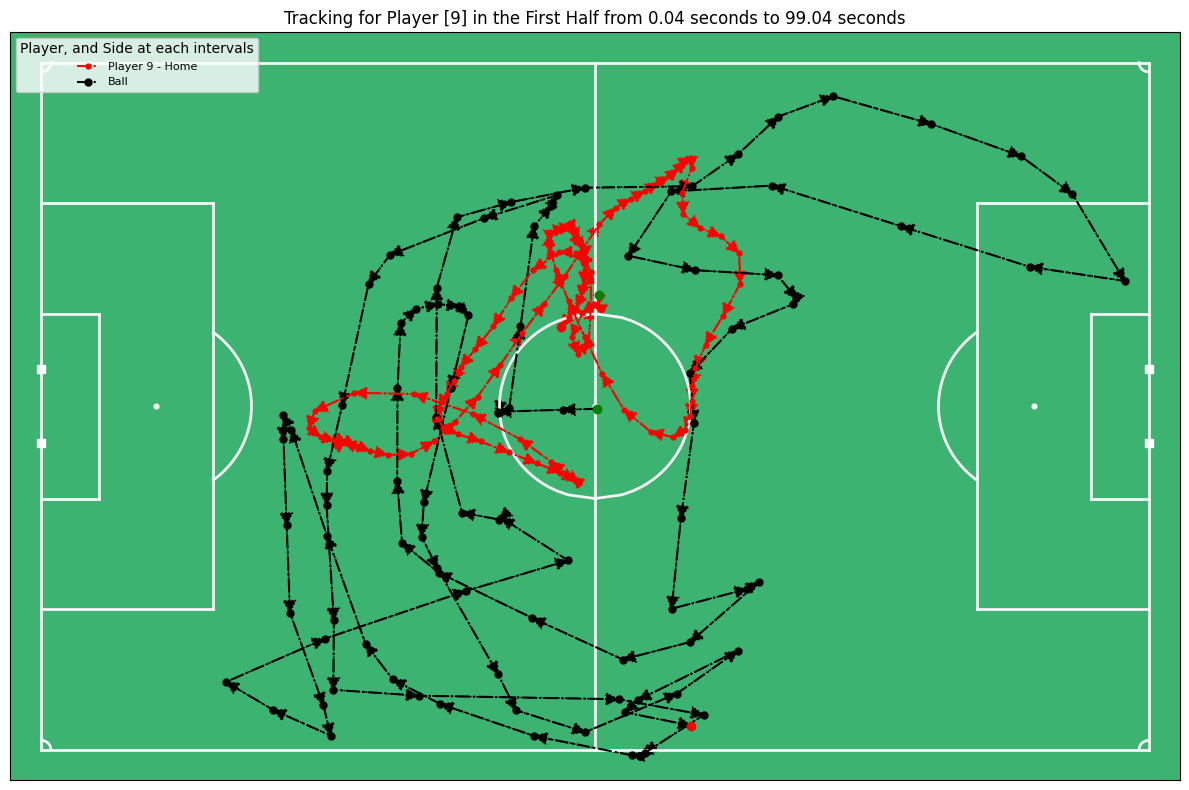

In [107]:
player_tracking(avg_1_sec, [9], sides=["Home"])

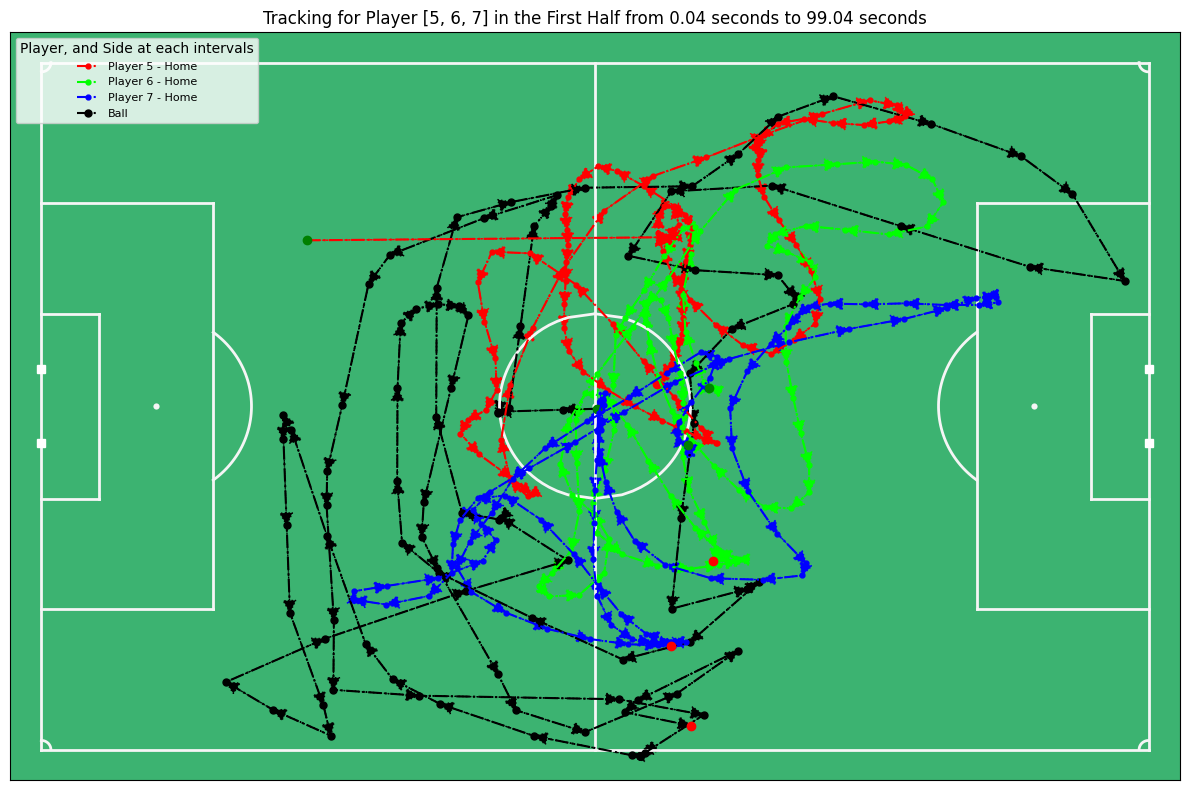

In [108]:
player_tracking(avg_1_sec, [5, 6, 7], sides=["Home"]*3)

In [109]:
# Calculate balls and players speed and direction
def speed_dir(dataset: pd.DataFrame) -> pd.DataFrame:
    temp_data = copy.deepcopy(dataset)
    player_columns = temp_data.columns[2:]

    for i in range(0, player_columns.shape[0] - 1, 2):
        # Calculate Euclidean distance between consecutive points
        ply_x, ply_y = player_columns[i], player_columns[i + 1]
        
        x_diff = temp_data[ply_x].diff()
        y_diff = temp_data[ply_y].diff()
        distance = np.sqrt(x_diff**2 + y_diff**2)
        
        # Calculate time difference between frames
        time_diff = temp_data['Time[s]'].diff()
        
        # Calculate speed (distance / time)
        # Note: First row will be NaN as we can't calculate speed for a single point
        speed = distance / time_diff
        direction = np.arctan2(x_diff, y_diff)

        if "ball" in ply_x:
            temp_data[f"ball_speed"] = speed
            temp_data[f"ball_direction"] = direction
        else:
            players_num = ply_x[7]
            if len(ply_x) == 11:
                players_num = ply_x[7:9]

            temp_data[f"P_{players_num}_speed"] = speed
            temp_data[f"P_{players_num}_direction"] = direction

    return temp_data

In [110]:
avg_1_sec

,Period,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,Home-P_4-y,...,Away-P_21-x,Away-P_21-y,Away-P_22-x,Away-P_22-y,Away-P_23-x,Away-P_23-y,Away-P_24-x,Away-P_24-y,ball-x,ball-y
1,1.0,0.04,0.647560,0.283644,0.677520,0.428030,0.696592,0.555645,0.644147,0.762736,...,0.432839,0.357528,0.497823,0.014630,0.501770,0.501450,0.495170,0.362340,0.502160,0.503760
2,1.0,1.04,0.647150,0.275018,0.677629,0.426852,0.686746,0.549754,0.644875,0.767359,...,0.432688,0.377177,0.495778,0.024554,0.501954,0.502422,0.495172,0.362320,0.502160,0.503760
3,1.0,2.04,0.649075,0.267862,0.677262,0.426183,0.676346,0.545278,0.643126,0.777459,...,0.434040,0.376211,0.495640,0.021007,0.502760,0.504104,0.497760,0.361457,0.470664,0.505236
4,1.0,3.04,0.650808,0.270631,0.675158,0.425478,0.665320,0.549432,0.641822,0.791985,...,0.439949,0.372589,0.504589,0.017182,0.511515,0.507609,0.511674,0.367192,0.412815,0.508063
5,1.0,4.04,0.651694,0.280151,0.676261,0.421896,0.657516,0.555598,0.646048,0.804760,...,0.454579,0.368341,0.529735,0.012959,0.534513,0.518531,0.539336,0.385298,0.412500,0.510373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1.0,95.04,0.684736,0.347691,0.705132,0.574020,0.665660,0.796998,0.533835,0.991324,...,0.469611,0.830619,0.620249,0.513454,0.661462,0.415208,0.592110,0.820090,0.574086,0.918220
97,1.0,96.04,0.688511,0.359455,0.723160,0.610179,0.665004,0.853710,0.560912,0.988387,...,0.490528,0.845969,0.627039,0.527022,0.669124,0.444810,0.615717,0.850423,0.628999,0.855877
98,1.0,97.04,0.691733,0.361788,0.740839,0.634582,0.672151,0.896891,0.585750,0.973080,...,0.507897,0.858088,0.631694,0.543294,0.670372,0.478440,0.637200,0.843921,0.539116,0.927579
99,1.0,98.04,0.692347,0.360227,0.740757,0.642786,0.690913,0.911300,0.597130,0.961983,...,0.520422,0.861600,0.631526,0.561417,0.665106,0.507191,0.637781,0.829780,0.527116,0.945611


# Tracking players closest to the ball using frames

In [111]:
period_1_data

,Period,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,Home-P_4-y,...,Away-P_21-x,Away-P_21-y,Away-P_22-x,Away-P_22-y,Away-P_23-x,Away-P_23-y,Away-P_24-x,Away-P_24-y,ball-x,ball-y
1,1,0.04,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.503760
2,1,0.08,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.503760
3,1,0.12,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.503760
4,1,0.16,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.503760
5,1,0.20,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.503760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39996,1,1599.84,0.75401,0.05765,0.80377,0.14736,0.82123,0.47841,0.79425,0.65911,...,0.61583,0.42294,0.74865,0.33770,0.78715,0.48973,0.79312,0.09089,0.70164,-0.014510
39997,1,1599.88,0.75494,0.05775,0.80455,0.14743,0.82165,0.47780,0.79469,0.65856,...,0.61612,0.42254,0.74874,0.33695,0.78743,0.48877,0.79396,0.08936,0.70107,-0.016440
39998,1,1599.92,0.75587,0.05785,0.80536,0.14751,0.82206,0.47718,0.79512,0.65805,...,0.61644,0.42214,0.74883,0.33609,0.78764,0.48794,0.79480,0.08783,0.70049,-0.018360
39999,1,1599.96,0.75679,0.05784,0.80614,0.14783,0.82244,0.47661,0.79555,0.65754,...,0.61674,0.42173,0.74892,0.33541,0.78784,0.48710,0.79562,0.08641,0.70049,-0.018465


In [112]:
temp_period_1_data = speed_dir(period_1_data)

In [113]:
temp_period_1_data

,Period,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,Home-P_4-y,...,P_21_speed,P_21_direction,P_22_speed,P_22_direction,P_23_speed,P_23_direction,P_24_speed,P_24_direction,ball_speed,ball_direction
1,1,0.04,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.08,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1,0.12,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1,0.16,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,1,0.20,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39996,1,1599.84,0.75401,0.05765,0.80377,0.14736,0.82123,0.47841,0.79425,0.65911,...,0.012500,2.498092,0.018951,2.995964,0.024520,2.852089,0.046517,2.661120,0.050382,-2.849661
39997,1,1599.88,0.75494,0.05775,0.80455,0.14743,0.82165,0.47780,0.79469,0.65856,...,0.012352,2.514284,0.018885,3.022164,0.025000,2.857799,0.043636,2.639502,0.050310,-2.854420
39998,1,1599.92,0.75587,0.05785,0.80536,0.14751,0.82206,0.47718,0.79512,0.65805,...,0.012806,2.466852,0.021617,3.037321,0.021404,2.893781,0.043636,2.639502,0.050142,-2.848226
39999,1,1599.96,0.75679,0.05784,0.80614,0.14783,0.82244,0.47661,0.79555,0.65754,...,0.012701,2.509902,0.017148,3.010005,0.021587,2.907849,0.040994,2.617908,0.002631,3.141593


In [114]:
ply_tra = temp_period_1_data.loc[51:1000, "Home-P_1-x":]
ply_tra

,Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,Home-P_4-y,Home-P_5-x,Home-P_5-y,...,P_21_speed,P_21_direction,P_22_speed,P_22_direction,P_23_speed,P_23_direction,P_24_speed,P_24_direction,ball_speed,ball_direction
51,0.64787,0.27031,0.67763,0.42630,0.68143,0.54622,0.64436,0.77154,0.57283,0.25354,...,0.000791,1.249046,0.001820,-2.863293,0.006250,3.141593,0.006718,2.356194,0.000000,0.000000
52,0.64797,0.27005,0.67765,0.42629,0.68101,0.54602,0.64428,0.77197,0.57270,0.25348,...,0.002016,2.622447,0.001061,-0.785398,0.001346,-2.761086,0.006052,2.473303,0.044045,-1.525373
53,0.64805,0.26978,0.67767,0.42637,0.68060,0.54582,0.64418,0.77242,0.57257,0.25351,...,0.002500,2.498092,0.001768,-2.999696,0.001768,-2.356194,0.002850,2.480549,0.067578,-1.522685
54,0.64815,0.26943,0.67769,0.42634,0.68020,0.54562,0.64409,0.77287,0.57245,0.25345,...,0.002500,2.498092,0.001820,-2.863293,0.001953,-2.265535,0.005706,2.638749,0.067578,-1.522685
55,0.64826,0.26908,0.67770,0.42630,0.67978,0.54545,0.64398,0.77334,0.57232,0.25338,...,0.002500,2.498092,0.004250,3.141593,0.002358,-2.129396,0.003052,2.530867,0.067567,-1.526381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.58268,0.29811,0.61293,0.67853,0.59248,0.79307,0.44577,0.91592,0.39659,0.51147,...,0.010610,-0.969723,0.008500,-1.570796,0.008867,-2.276365,0.032035,-2.544932,0.066262,-2.195432
997,0.58243,0.29830,0.61220,0.67781,0.59208,0.79291,0.44483,0.91591,0.39588,0.51211,...,0.011164,-0.976583,0.008782,-1.485291,0.008902,-2.236766,0.033287,-2.570255,0.064460,-2.196456
998,0.58216,0.29852,0.61147,0.67710,0.59164,0.79276,0.44390,0.91589,0.39517,0.51269,...,0.011180,-1.107149,0.009124,-1.405648,0.009737,-2.301703,0.034132,-2.586099,0.066262,-2.195432
999,0.58189,0.29865,0.61072,0.67640,0.59116,0.79262,0.44300,0.91578,0.39445,0.51321,...,0.011632,-1.078311,0.009582,-1.306833,0.010115,-2.268699,0.034214,-2.596161,0.067861,-2.196613


In [115]:
players, ball, sp_dir = ply_tra.loc[:,"Home-P_1-x":"Away-P_24-y"], ply_tra.loc[:,"ball-x":"ball-y"], ply_tra.loc[:,"P_1_speed":]

In [116]:
players.head()

,Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,Home-P_4-y,Home-P_5-x,Home-P_5-y,...,Away-P_20-x,Away-P_20-y,Away-P_21-x,Away-P_21-y,Away-P_22-x,Away-P_22-y,Away-P_23-x,Away-P_23-y,Away-P_24-x,Away-P_24-y
51,0.64787,0.27031,0.67763,0.42630,0.68143,0.54622,0.64436,0.77154,0.57283,0.25354,...,0.40042,0.51021,0.43295,0.37750,0.49511,0.02246,0.50216,0.50376,0.49565,0.36179
52,0.64797,0.27005,0.67765,0.42629,0.68101,0.54602,0.64428,0.77197,0.57270,0.25348,...,0.40045,0.51021,0.43299,0.37743,0.49508,0.02249,0.50214,0.50371,0.49580,0.36160
53,0.64805,0.26978,0.67767,0.42637,0.68060,0.54582,0.64418,0.77242,0.57257,0.25351,...,0.40049,0.51020,0.43305,0.37735,0.49507,0.02242,0.50209,0.50366,0.49587,0.36151
54,0.64815,0.26943,0.67769,0.42634,0.68020,0.54562,0.64409,0.77287,0.57245,0.25345,...,0.40054,0.51018,0.43311,0.37727,0.49505,0.02235,0.50203,0.50361,0.49598,0.36131
55,0.64826,0.26908,0.67770,0.42630,0.67978,0.54545,0.64398,0.77334,0.57232,0.25338,...,0.40059,0.51010,0.43317,0.37719,0.49505,0.02218,0.50195,0.50356,0.49605,0.36121


In [117]:
ball.head()

,ball-x,ball-y
51,0.50216,0.50376
52,0.50040,0.50384
53,0.49770,0.50397
54,0.49500,0.50410
55,0.49230,0.50422


In [118]:
sp_dir.head()

,P_1_speed,P_1_direction,P_2_speed,P_2_direction,P_3_speed,P_3_direction,P_4_speed,P_4_direction,P_5_speed,P_5_direction,...,P_21_speed,P_21_direction,P_22_speed,P_22_direction,P_23_speed,P_23_direction,P_24_speed,P_24_direction,ball_speed,ball_direction
51,0.006562,2.831890,0.000750,0.000000,0.011319,-2.103640,0.009169,-0.192048,0.002926,-1.919567,...,0.000791,1.249046,0.001820,-2.863293,0.006250,3.141593,0.006718,2.356194,0.000000,0.000000
52,0.006964,2.774419,0.000559,2.034444,0.011630,-2.015216,0.010934,-0.183943,0.003579,-2.003204,...,0.002016,2.622447,0.001061,-0.785398,0.001346,-2.761086,0.006052,2.473303,0.044045,-1.525373
53,0.007040,2.853537,0.002062,0.244979,0.011404,-2.024640,0.011524,-0.218669,0.003335,-1.343997,...,0.002500,2.498092,0.001768,-2.999696,0.001768,-2.356194,0.002850,2.480549,0.067578,-1.522685
54,0.009100,2.863293,0.000901,2.553590,0.011180,-2.034444,0.011473,-0.197396,0.003354,-2.034444,...,0.002500,2.498092,0.001820,-2.863293,0.001953,-2.265535,0.005706,2.638749,0.067578,-1.522685
55,0.009172,2.837082,0.001031,2.896614,0.011328,-1.955401,0.012068,-0.229904,0.003691,-2.064738,...,0.002500,2.498092,0.004250,3.141593,0.002358,-2.129396,0.003052,2.530867,0.067567,-1.526381


In [119]:
result = pd.DataFrame(index=ply_tra.index)
result["Time[s]"] = period_1_data["Time[s]"]

for i in range(0, players.shape[1] - 1, 2):
    ply_x, ply_y = players.iloc[:, i], players.iloc[:, i + 1]
    eu_x = np.square(ply_x - ball["ball-x"])
    eu_y = np.square(ply_y - ball["ball-y"])
    distance = np.sqrt(eu_x + eu_y)
    result[f"{players.columns[i][:-2]}"] = distance

In [120]:
result

,Time[s],Home-P_1,Home-P_2,Home-P_3,Home-P_4,Home-P_5,Home-P_6,Home-P_7,Home-P_8,Home-P_9,...,Away-P_15,Away-P_16,Away-P_17,Away-P_18,Away-P_19,Away-P_20,Away-P_21,Away-P_22,Away-P_23,Away-P_24
51,2.04,0.275191,0.191807,0.184230,0.303195,0.260008,0.106888,0.098654,0.284414,0.150812,...,0.337720,0.203416,0.204798,0.238774,0.410884,0.101944,0.143985,0.481352,0.000000,0.142119
52,2.08,0.276468,0.193472,0.185470,0.304295,0.260591,0.108682,0.099907,0.284570,0.151233,...,0.337110,0.201720,0.203449,0.238035,0.410777,0.100153,0.143261,0.481379,0.001745,0.142314
53,2.12,0.278299,0.195987,0.187627,0.305813,0.261411,0.111383,0.101924,0.284831,0.151749,...,0.336165,0.199131,0.201267,0.236808,0.410660,0.097409,0.142170,0.481557,0.004401,0.142472
54,2.16,0.280223,0.198550,0.189797,0.307352,0.262343,0.114103,0.103974,0.285070,0.152239,...,0.335219,0.196536,0.199054,0.235575,0.410510,0.094655,0.141125,0.481750,0.007047,0.142793
55,2.20,0.282160,0.201109,0.191960,0.308921,0.263294,0.116815,0.106052,0.285337,0.152771,...,0.334270,0.193946,0.196844,0.234355,0.410418,0.091898,0.140118,0.482048,0.009673,0.143059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,39.84,0.742588,0.490045,0.423000,0.253985,0.465537,0.318535,0.176525,0.106239,0.384526,...,0.108232,0.051512,0.433519,0.623080,0.187478,0.209338,0.395606,0.825735,0.333730,0.421392
997,39.88,0.742114,0.490809,0.424168,0.255057,0.464217,0.318533,0.175973,0.108728,0.383472,...,0.110850,0.049247,0.432240,0.621804,0.188378,0.208379,0.394669,0.825016,0.335115,0.422424
998,39.92,0.741610,0.491604,0.425346,0.256206,0.462951,0.318607,0.175461,0.111320,0.382446,...,0.113537,0.046960,0.430991,0.620486,0.189398,0.207377,0.393766,0.824260,0.336558,0.423512
999,39.96,0.741183,0.492404,0.426526,0.257448,0.461732,0.318740,0.175032,0.113971,0.381411,...,0.116272,0.044567,0.429691,0.619322,0.190510,0.206425,0.392839,0.823452,0.338028,0.424642


In [121]:
idx = result.min(axis=1).round(4)
closest_to_ball = result.idxmin(axis=1)
print("\n".join(f"{i} - {ply} - {dis}" for i, ply, dis in zip(result.index, closest_to_ball, idx)))

51 - Away-P_23 - 0.0
52 - Away-P_23 - 0.0017
53 - Away-P_23 - 0.0044
54 - Away-P_23 - 0.007
55 - Away-P_23 - 0.0097
56 - Away-P_23 - 0.0123
57 - Away-P_23 - 0.0149
58 - Away-P_23 - 0.0177
59 - Away-P_23 - 0.0205
60 - Away-P_23 - 0.0233
61 - Away-P_23 - 0.0261
62 - Away-P_23 - 0.0289
63 - Away-P_23 - 0.0317
64 - Away-P_23 - 0.0345
65 - Away-P_23 - 0.0374
66 - Away-P_23 - 0.0402
67 - Away-P_23 - 0.0431
68 - Away-P_23 - 0.0459
69 - Away-P_23 - 0.0488
70 - Away-P_20 - 0.0498
71 - Away-P_20 - 0.047
72 - Away-P_20 - 0.0442
73 - Away-P_20 - 0.0413
74 - Away-P_20 - 0.0385
75 - Away-P_20 - 0.0357
76 - Away-P_20 - 0.0329
77 - Away-P_20 - 0.03
78 - Away-P_20 - 0.0272
79 - Away-P_20 - 0.0244
80 - Away-P_20 - 0.0216
81 - Away-P_20 - 0.0187
82 - Away-P_20 - 0.0159
83 - Away-P_20 - 0.0131
84 - Away-P_20 - 0.0102
85 - Away-P_20 - 0.0074
86 - Away-P_20 - 0.0045
87 - Away-P_20 - 0.0017
88 - Away-P_20 - 0.0002
89 - Away-P_20 - 0.0002
90 - Away-P_20 - 0.0002
91 - Away-P_20 - 0.0002
92 - Away-P_20 - 0.0002

In [122]:
min_dist_to_ball = pd.DataFrame(index=ply_tra.index)
min_dist_to_ball["Time[s]"] = period_1_data["Time[s]"]

for i, (index, c) in enumerate(zip(min_dist_to_ball.index, closest_to_ball)):        
    min_dist_to_ball.loc[index, "Home-P_0-x"] = period_1_data.loc[index, f"{c}-x"]
    min_dist_to_ball.loc[index, "Home-P_0-y"] = period_1_data.loc[index, f"{c}-y"]
        
    min_dist_to_ball.loc[index, f"{c}-x"] = period_1_data.loc[index, f"{c}-x"]
    min_dist_to_ball.loc[index, f"{c}-y"] = period_1_data.loc[index, f"{c}-y"]
    
min_dist_to_ball["ball-x"] = period_1_data["ball-x"]
min_dist_to_ball["ball-y"] = period_1_data["ball-y"]

min_dist_to_ball

,Time[s],Home-P_0-x,Home-P_0-y,Away-P_23-x,Away-P_23-y,Away-P_20-x,Away-P_20-y,Home-P_9-x,Home-P_9-y,Away-P_21-x,...,Away-P_19-x,Away-P_19-y,Home-P_4-x,Home-P_4-y,Home-P_3-x,Home-P_3-y,Home-P_10-x,Home-P_10-y,ball-x,ball-y
51,2.04,0.50216,0.50376,0.50216,0.50376,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50216,0.50376
52,2.08,0.50214,0.50371,0.50214,0.50371,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50040,0.50384
53,2.12,0.50209,0.50366,0.50209,0.50366,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.49770,0.50397
54,2.16,0.50203,0.50361,0.50203,0.50361,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.49500,0.50410
55,2.20,0.50195,0.50356,0.50195,0.50356,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.49230,0.50422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,39.84,0.23524,0.92331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.23524,0.92331,0.19216,0.92972
997,39.88,0.23401,0.92251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.23401,0.92251,0.19007,0.92821
998,39.92,0.23275,0.92170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.23275,0.92170,0.18792,0.92666
999,39.96,0.15779,0.89034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.18572,0.92507


In [123]:
delete_idx = sp_dir[sp_dir["ball_speed"] > BALL_POSSESSION_SPEED].index
min_dist_to_ball = min_dist_to_ball.loc[~min_dist_to_ball.index.isin(delete_idx), :]
min_dist_to_ball

,Time[s],Home-P_0-x,Home-P_0-y,Away-P_23-x,Away-P_23-y,Away-P_20-x,Away-P_20-y,Home-P_9-x,Home-P_9-y,Away-P_21-x,...,Away-P_19-x,Away-P_19-y,Home-P_4-x,Home-P_4-y,Home-P_3-x,Home-P_3-y,Home-P_10-x,Home-P_10-y,ball-x,ball-y
51,2.04,0.50216,0.50376,0.50216,0.50376,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50216,0.50376
52,2.08,0.50214,0.50371,0.50214,0.50371,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50040,0.50384
88,3.52,0.40435,0.50838,NaN,NaN,0.40435,0.50838,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.40419,0.50835
89,3.56,0.40453,0.50842,NaN,NaN,0.40453,0.50842,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.40435,0.50838
90,3.60,0.40471,0.50846,NaN,NaN,0.40471,0.50846,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.40453,0.50842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,38.12,0.27669,0.99033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.27676,0.99018
954,38.16,0.27663,0.99045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.27669,0.99033
955,38.20,0.27656,0.99053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.27663,0.99045
956,38.24,0.27648,0.99059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.27656,0.99053


In [124]:
temp = list(min_dist_to_ball.iloc[:, 3:-2].idxmax(axis=1))
sides = []
player_col = []
size = len(temp)
for i in range(size):
    end = 8
    if len(temp[i]) == 11:
        end = 9
    player_col.append(temp[i][7:end])
    sides.append(temp[i][:4])

In [125]:
def get_changes(lst: list[str]):
    change_nums = [lst[0]]
    change_indices = [0]
    for i in range(1, len(lst)):
        if lst[i] != lst[i - 1]:
            change_nums.append(lst[i])
            change_indices.append(i)
            
    return change_nums, change_indices

def get_items(lst: list[int], lst2: list[str]):
    items = []
    for i in lst:
        items.append(lst2[i])

    return items

In [126]:
dif_player_col, idxs = get_changes(player_col)
dif_sides = get_items(idxs, sides)
dif_min_dist_to_ball = min_dist_to_ball.iloc[idxs, :]

In [127]:
dif_min_dist_to_ball

,Time[s],Home-P_0-x,Home-P_0-y,Away-P_23-x,Away-P_23-y,Away-P_20-x,Away-P_20-y,Home-P_9-x,Home-P_9-y,Away-P_21-x,...,Away-P_19-x,Away-P_19-y,Home-P_4-x,Home-P_4-y,Home-P_3-x,Home-P_3-y,Home-P_10-x,Home-P_10-y,ball-x,ball-y
51,2.04,0.50216,0.50376,0.50216,0.50376,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50216,0.503760
88,3.52,0.40435,0.50838,NaN,NaN,0.40435,0.50838,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.40419,0.508350
187,7.48,0.44388,0.22400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.44312,0.224340
284,11.36,0.31168,0.27972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.31207,0.279520
348,13.92,0.26170,0.57862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.26207,0.578180
425,17.00,0.26768,0.90767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.26814,0.907290
505,20.20,0.62314,0.92521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.62314,0.92521,NaN,NaN,0.62111,0.924170
535,21.40,0.59375,0.97572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.59375,0.97572,NaN,NaN,NaN,NaN,0.54097,1.008976
549,21.96,0.49766,0.95348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.49766,0.95348,NaN,NaN,NaN,NaN,NaN,NaN,0.54097,1.008913
617,24.68,0.51209,0.96850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.54097,1.008607


In [128]:
assert len(dif_min_dist_to_ball) == len(dif_player_col)

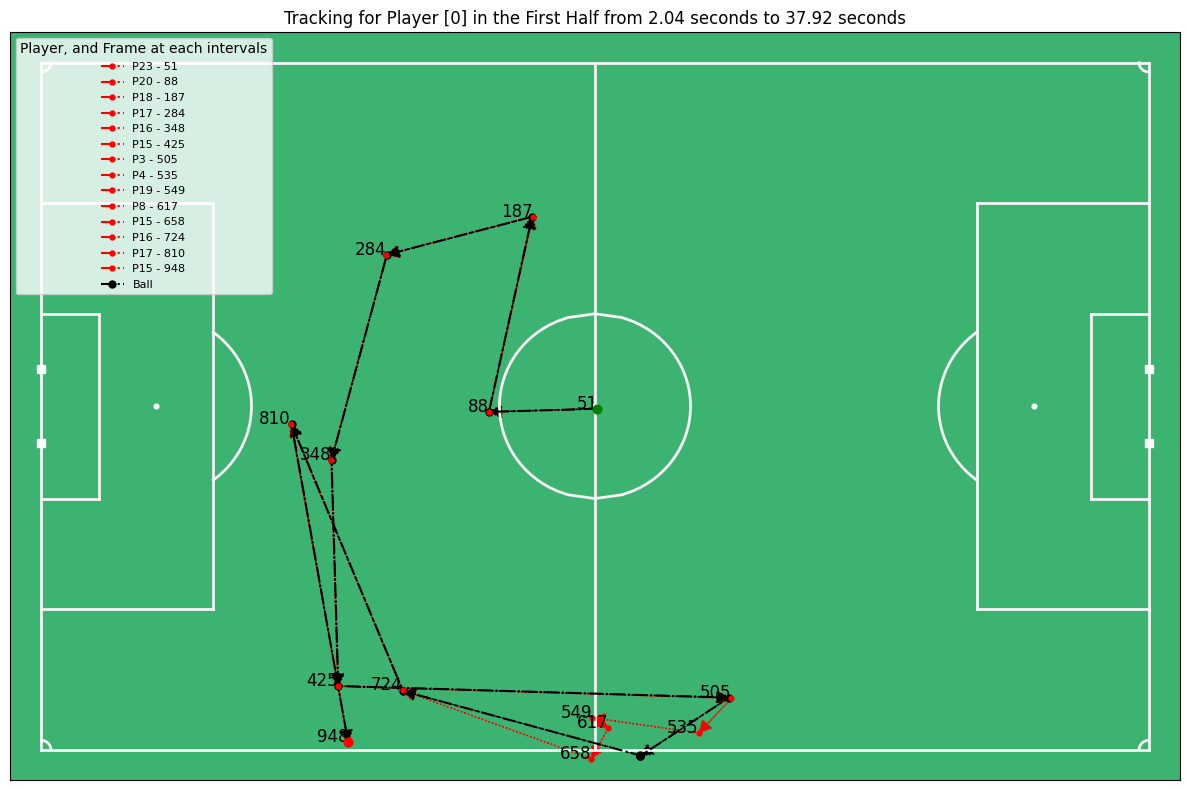

In [129]:
player_tracking(dif_min_dist_to_ball, plot_ball=True, players=[0], use_annotation=dif_player_col, sides=["Home"]) # Putting down [0] and ["Home"] because we don't want it to be different color and it's easier

# Classification

In [130]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [131]:
dif_min_dist_to_ball

,Time[s],Home-P_0-x,Home-P_0-y,Away-P_23-x,Away-P_23-y,Away-P_20-x,Away-P_20-y,Home-P_9-x,Home-P_9-y,Away-P_21-x,...,Away-P_19-x,Away-P_19-y,Home-P_4-x,Home-P_4-y,Home-P_3-x,Home-P_3-y,Home-P_10-x,Home-P_10-y,ball-x,ball-y
51,2.04,0.50216,0.50376,0.50216,0.50376,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50216,0.503760
88,3.52,0.40435,0.50838,NaN,NaN,0.40435,0.50838,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.40419,0.508350
187,7.48,0.44388,0.22400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.44312,0.224340
284,11.36,0.31168,0.27972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.31207,0.279520
348,13.92,0.26170,0.57862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.26207,0.578180
425,17.00,0.26768,0.90767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.26814,0.907290
505,20.20,0.62314,0.92521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.62314,0.92521,NaN,NaN,0.62111,0.924170
535,21.40,0.59375,0.97572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.59375,0.97572,NaN,NaN,NaN,NaN,0.54097,1.008976
549,21.96,0.49766,0.95348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.49766,0.95348,NaN,NaN,NaN,NaN,NaN,NaN,0.54097,1.008913
617,24.68,0.51209,0.96850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.54097,1.008607


In [132]:
df_event = pd.read_csv("Sample_Game_2_RawEventsData.csv")
df_event_period_1 = df_event[df_event["Period"] == 1]
df_event_period_1

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.50,0.50,0.40,0.51
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,0.43,0.50,0.44,0.22
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,0.47,0.19,0.31,0.28
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,0.29,0.32,0.26,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1024,Home,PASS,NaN,1,66843,2673.72,66878,2675.12,Player6,Player5,0.47,0.16,0.37,0.43
1025,Home,PASS,NaN,1,66929,2677.16,66961,2678.44,Player5,Player7,0.34,0.49,0.22,0.87
1026,Home,SHOT,OFF TARGET-OUT,1,67067,2682.68,67107,2684.28,Player7,NaN,0.13,0.77,-0.02,0.41
1027,Away,RECOVERY,NaN,1,67118,2684.72,67118,2684.72,Player25,NaN,0.04,0.50,NaN,NaN


In [260]:
df_event_period_1_y = df_event_period_1[["Type", "Start Frame", "End Frame"]]
df_event_period_1_y["Current Player"] = change_player_name(df_event_period_1["To"].combine_first(df_event_period_1["From"]))
df_event_period_1_y

C:\Users\noill\AppData\Local\Temp\ipykernel_73656\1484036386.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event_period_1_y["Current Player"] = change_player_name(df_event_period_1["To"].combine_first(df_event_period_1["From"]))


,Type,Start Frame,End Frame,Current Player
0,SET PIECE,51,51,Away-P_23
1,PASS,51,87,Away-P_20
2,PASS,146,186,Away-P_18
3,PASS,248,283,Away-P_17
4,PASS,316,346,Away-P_16
...,...,...,...,...
1024,PASS,66843,66878,Home-P_5
1025,PASS,66929,66961,Home-P_7
1026,SHOT,67067,67107,Home-P_7
1027,RECOVERY,67118,67118,Away-P_25


In [261]:
start_frames = np.array(df_event_period_1_y["Start Frame"].iloc[1:]) + 2
end_frames = np.array(df_event_period_1_y["End Frame"].iloc[:-1]) - 2

In [262]:
assert start_frames.shape == end_frames.shape
frame_ranges = [np.sort(np.array([i, j])) for i, j in zip(end_frames, start_frames)]

In [263]:
frame_ranges

[array([49, 53], dtype=int64),
 array([ 85, 148], dtype=int64),
 array([184, 250], dtype=int64),
 array([281, 318], dtype=int64),
 array([344, 397], dtype=int64),
 array([421, 453], dtype=int64),
 array([502, 506], dtype=int64),
 array([502, 506], dtype=int64),
 array([502, 506], dtype=int64),
 array([502, 506], dtype=int64),
 array([532, 674], dtype=int64),
 array([670, 674], dtype=int64),
 array([720, 770], dtype=int64),
 array([806, 857], dtype=int64),
 array([923, 927], dtype=int64),
 array([945, 958], dtype=int64),
 array([1014, 1018], dtype=int64),
 array([1085, 1086], dtype=int64),
 array([1082, 1086], dtype=int64),
 array([1082, 1086], dtype=int64),
 array([1089, 1119], dtype=int64),
 array([1085, 1123], dtype=int64),
 array([1119, 1157], dtype=int64),
 array([1168, 1172], dtype=int64),
 array([1222, 1291], dtype=int64),
 array([1317, 1394], dtype=int64),
 array([1427, 1433], dtype=int64),
 array([1429, 1469], dtype=int64),
 array([1487, 1491], dtype=int64),
 array([1576, 1578]

In [270]:
X = [i[:-2] for i in dif_min_dist_to_ball.iloc[:, 3:-2].idxmax(axis=1)]
X_idxs = list(dif_min_dist_to_ball.index)
assert len(X) == len(X_idxs)
[print(f"{i} -- {j}") for i, j in zip(X_idxs, X)]
1

51 -- Away-P_23
88 -- Away-P_20
187 -- Away-P_18
284 -- Away-P_17
348 -- Away-P_16
425 -- Away-P_15
505 -- Home-P_3
535 -- Home-P_4
549 -- Away-P_19
617 -- Home-P_8
658 -- Away-P_15
724 -- Away-P_16
810 -- Away-P_17
948 -- Away-P_15


1

In [284]:
def find_idxs_label(event_dataset, ranges, data, data_idxs):
    assert len(data) == len(data_idxs)
    
    result = []
    i = 0
    j = 0
    while i < len(ranges) and j < len(data_idxs):
        item = data_idxs[j]
        if item > ranges[i][0] and item < ranges[i][1]:
            print(item, j, i, event_dataset.loc[i, "Current Player"], data[j])
            if event_dataset.loc[i, "Current Player"] == data[j]:
                result.append(i)
                j += 1
        i += 1

    return result

In [285]:
find_idxs_label(df_event_period_1_y, frame_ranges, X, X_idxs)

51 0 0 Away-P_23 Away-P_23
88 1 1 Away-P_20 Away-P_20
187 2 2 Away-P_18 Away-P_18
284 3 3 Away-P_17 Away-P_17
348 4 4 Away-P_16 Away-P_16
425 5 5 Away-P_15 Away-P_15
505 6 6 Away-P_15 Home-P_3
505 6 7 Away-P_23 Home-P_3
505 6 8 Home-P_3 Home-P_3
535 7 10 Home-P_3 Home-P_4


[0, 1, 2, 3, 4, 5, 8]

In [ ]:
clf = RandomForestClassifier(random_state=0)

In [177]:
# clf.fit(X, y)